In [1]:
from typing import Optional, Union

import numpy as np
from numpy.typing import ArrayLike
from tabulate import tabulate
import matplotlib.pyplot as plt

Generate synthetic data

In [2]:
# TODO: vector correct/wrong and order and uncertainty
num_ood_obs = 5000
num_id_obs = 5000
id_accuracy = 0.95
shuffle_rate = 0.1 # TODO


In [3]:
num_id_correct = int(num_id_obs * id_accuracy)
num_id_wrong = num_id_obs - num_id_correct

In [4]:
y_pred_correct = np.concatenate(
    (np.zeros((num_ood_obs)), np.zeros((num_id_wrong)), np.ones((num_id_correct)))
)

y_pred_uncertainty = np.concatenate(
    (
        np.random.normal(2.5, 0.5, num_ood_obs),
        np.random.normal(1.5, 0.5, num_id_wrong),
        np.random.normal(0.1, 0.1, num_id_correct),
    )
)
# make negative values 0
y_pred_uncertainty = np.maximum(y_pred_uncertainty, 0)

np.random.seed(seed=44)
random_draws = np.random.random(y_pred_uncertainty.size)
y_reject_order = np.lexsort((random_draws, y_pred_uncertainty))
y_reject_order = np.flip(y_reject_order, axis=0)

y_pred_confidence = y_pred_uncertainty / np.max(y_pred_uncertainty)
y_pred_confidence = np.flip(y_pred_confidence, axis=0)

y_pred_tu = y_pred_uncertainty
y_pred_au = y_pred_uncertainty / 2
y_pred_eu = y_pred_uncertainty / 2
uncertainty_dict = {"TU": y_pred_tu, "AU": y_pred_au, "EU": y_pred_eu}


In [5]:
def confusion_matrix_rej(
    correct: ArrayLike,
    unc_ary: ArrayLike,
    threshold: float,
    relative: bool = True,
    show: bool = False,
    seed: int = 44,
) -> tuple[int, int, int, int]:
    """Compute confusion matrix with 2 axes: (i) correct/incorrect, (ii) rejected/non-rejected.

    Parameters
    ----------
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    unc_ary : ArrayLike
        1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
    threshold : float
        Rejection threshold.
    relative : bool, optional
        Use relative rejection, otherwise absolute rejection.
        Default: True
    show : bool, optional
        Print confusion matrix to console.
        Default: False
    seed: int, optional
        Seed value for random rejection.
        Default 44

    Returns
    -------
    n_cor_rej : int
        Number of correct observations that are rejected.
    n_cor_nonrej : int
        Number of correct observations that are not rejected.
    n_incor_rej : int
        Number of incorrect observations that are rejected.
    n_incor_nonrej : int
        Number of incorrect observations that are not rejected.
    """
    # input checks
    if threshold < 0:
        raise ValueError("Threshold must be non-negative.")
    if relative and threshold > 1:
        raise ValueError("Threshold must be less than or equal to 1.")

    # axis 0: correct or incorrect
    idx_correct = np.where(correct == 1.0)[0]
    idx_incorrect = np.where(correct == 0.0)[0]

    # axis 1: rejected or non-rejected
    if relative:
        # relative rejection
        n_preds_rej = int(threshold * correct.size)
        # use uncertainty array
        # sort by unc_ary, then by random numbers random_draws
        # -> if values equal e.g. 1.0 -> rejected randomly
        np.random.seed(seed=seed)
        random_draws = np.random.random(correct.size)
        idx = np.lexsort((random_draws, unc_ary))
        idx = np.flip(idx, axis=0)
        idx_rej = idx[:n_preds_rej]
        idx_nonrej = idx[n_preds_rej:]
    else:
        # absolute rejection
        y_reject = np.where(unc_ary >= threshold, 1, 0)
        idx_rej = np.where(y_reject == 1)[0]
        idx_nonrej = np.where(y_reject == 0)[0]

    # intersections
    idx_cor_rej = np.intersect1d(idx_correct, idx_rej)
    idx_cor_nonrej = np.intersect1d(idx_correct, idx_nonrej)
    idx_incor_rej = np.intersect1d(idx_incorrect, idx_rej)
    idx_incor_nonrej = np.intersect1d(idx_incorrect, idx_nonrej)
    n_cor_rej = idx_cor_rej.shape[0]
    n_cor_nonrej = idx_cor_nonrej.shape[0]
    n_incor_rej = idx_incor_rej.shape[0]
    n_incor_nonrej = idx_incor_nonrej.shape[0]
    if show:
        print( # TODO: use logging?
            tabulate(
                [
                    ["", "Non-rejected", "Rejected"],
                    ["Correct", n_cor_nonrej, n_cor_rej],
                    ["Incorrect", n_incor_nonrej, n_incor_rej],
                ],
                headers="firstrow",
            )
        )
    return n_cor_rej, n_cor_nonrej, n_incor_rej, n_incor_nonrej



print(confusion_matrix_rej(
    correct=y_pred_correct,
    unc_ary=y_pred_uncertainty,
    threshold=0.5,
    relative=True,
    show=True,
    seed=44,
))

print(confusion_matrix_rej(
    correct=y_pred_correct,
    unc_ary=y_pred_uncertainty,
    threshold=2.0,
    relative=False,
    show=True,
    seed=44,
))

             Non-rejected    Rejected
---------  --------------  ----------
Correct              4750           0
Incorrect             250        5000
(0, 4750, 5000, 250)
             Non-rejected    Rejected
---------  --------------  ----------
Correct              4750           0
Incorrect            1025        4225
(0, 4750, 4225, 1025)


In [6]:
def compute_metrics_rej(
    threshold: float,
    correct: ArrayLike,
    unc_ary: ArrayLike,
    relative: bool = True,
    show: bool = True,
    seed: int = 44,
) -> tuple[float, float, float]:
    """Compute 3 rejection metrics using relative or absolute threshold:
    - non-rejeced accuracy (NRA)
    - classification quality (CQ)
    - rejection quality (RQ)
    
    Parameters
    ----------
    threshold : float
        Rejection threshold.
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    unc_ary : ndarray
        1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
    relative : bool, optional
        Use relative rejection, otherwise absolute rejection.
        Default: True
    show : bool, optional
        Print confusion matrix to console.
        Default: True
    seed: int, optional
        Seed value for random rejection.
        Default 44
    
    Returns
    -------
    nonrej_acc : float
        Non-rejeced accuracy (NRA).
    class_quality : float
        Classification quality (CQ).
    rej_quality : float
        Rejection quality (RQ).
    Notes
    -----
    - rejection quality is undefined when `n_cor_rej=0`
        - if any observation is rejected: RQ = positive infinite
        - if no sample is rejected: RQ = 1
        - see: `Condessa et al. (2017) <https://doi.org/10.1016/j.patcog.2016.10.011>`_
    """
    n_cor_rej, n_cor_nonrej, n_incor_rej, n_incor_nonrej = confusion_matrix_rej(
        correct=correct,
        unc_ary=unc_ary,
        threshold=threshold,
        show=show,
        relative=relative,
        seed=seed,
    )

    # 3 metrics
    try:
        nonrej_acc = n_cor_nonrej / (n_incor_nonrej + n_cor_nonrej)
    except ZeroDivisionError:
        nonrej_acc = np.inf  # invalid
    try:
        class_quality = (n_cor_nonrej + n_incor_rej) / (
            n_cor_rej + n_cor_nonrej + n_incor_rej + n_incor_nonrej
        )
    except ZeroDivisionError:
        class_quality = np.inf  # invalid
    try:
        rej_quality = (n_incor_rej / n_cor_rej) / (
            (n_incor_rej + n_incor_nonrej) / (n_cor_rej + n_cor_nonrej)
        )
    except ZeroDivisionError:
        if (n_incor_rej + n_cor_rej) > 0:
            rej_quality = np.inf
        else:
            rej_quality = 1.0
    if show:
        data = [[nonrej_acc, class_quality, rej_quality]]
        print( # TODO: use logging instead of print
            "\n"
            + tabulate(
                data,
                headers=[
                    "Non-rejected accuracy",
                    "Classification quality",
                    "Rejection quality",
                ],
                floatfmt=".4f",
            )
        )
    return nonrej_acc, class_quality, rej_quality


print(compute_metrics_rej(
    threshold=0.5,
    correct=y_pred_correct,
    unc_ary=y_pred_uncertainty,
    relative=True,
    show=True,
    seed=44,
))

print(compute_metrics_rej(
    threshold=2.0,
    correct=y_pred_correct,
    unc_ary=y_pred_uncertainty,
    relative=False,
    show=True,
    seed=44,
))

             Non-rejected    Rejected
---------  --------------  ----------
Correct              4750           0
Incorrect             250        5000

  Non-rejected accuracy    Classification quality    Rejection quality
-----------------------  ------------------------  -------------------
                 0.9500                    0.9750                  inf
(0.95, 0.975, inf)
             Non-rejected    Rejected
---------  --------------  ----------
Correct              4750           0
Incorrect            1025        4225

  Non-rejected accuracy    Classification quality    Rejection quality
-----------------------  ------------------------  -------------------
                 0.8225                    0.8975                  inf
(0.8225108225108225, 0.8975, inf)


In [7]:
# class NonRejectedAccuracy:
#     def __init__(
#         self,
#         relative: bool = True,
#         seed: int = 44,
#     ):
#         self.relative = relative
#         self.seed = seed

#     def __call__(
#         self,
#         correct: ArrayLike,
#         unc_ary: ArrayLike,
#         threshold: float,
#     ):
#         _, n_cor_nonrej, _, n_incor_nonrej = confusion_matrix_rej(
#             correct=correct,
#             unc_ary=unc_ary,
#             threshold=threshold,
#             show=False,
#             relative=self.relative,
#             seed=self.seed,
#         )
#         try:
#             nonrej_acc = n_cor_nonrej / (n_incor_nonrej + n_cor_nonrej)
#         except ZeroDivisionError:
#             nonrej_acc = np.inf  # invalid
#         return nonrej_acc


# nra = NonRejectedAccuracy(relative=True, seed=44)
# print(nra(correct=y_pred_correct, unc_ary=y_pred_uncertainty, threshold=0.4))

In [8]:
def non_rejected_accuracy(
    correct: ArrayLike,
    unc_ary: ArrayLike,
    threshold: float,
    relative: bool = True,
    seed: int = 44,
) -> float:
    """Compute non-rejected accuracy (NRA).

    Parameters
    ----------
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    unc_ary : ndarray
        1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
    threshold : float
        Rejection threshold.
    relative : bool, optional
        Use relative rejection, otherwise absolute rejection.
        Default: True
    seed: int, optional
        Seed value for random rejection.
        Default 44

    Returns
    -------
    float
        Value of non-rejected accuracy.
    """
    _, n_cor_nonrej, _, n_incor_nonrej = confusion_matrix_rej(
        correct=correct,
        unc_ary=unc_ary,
        threshold=threshold,
        show=False,
        relative=relative,
        seed=seed,
    )
    try:
        nonrej_acc = n_cor_nonrej / (n_incor_nonrej + n_cor_nonrej)
    except ZeroDivisionError:
        nonrej_acc = np.inf  # invalid
    return nonrej_acc


def classification_quality(
    correct: ArrayLike,
    unc_ary: ArrayLike,
    threshold: float,
    relative: bool = True,
    seed: int = 44,
) -> float:
    """Compute classification quality (CQ).

    Parameters
    ----------
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    unc_ary : ndarray
        1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
    threshold : float
        Rejection threshold.
    relative : bool, optional
        Use relative rejection, otherwise absolute rejection.
        Default: True
    seed: int, optional
        Seed value for random rejection.
        Default 44

    Returns
    -------
    float
        Value of classification quality.
    """
    n_cor_rej, n_cor_nonrej, n_incor_rej, n_incor_nonrej = confusion_matrix_rej(
        correct=correct,
        unc_ary=unc_ary,
        threshold=threshold,
        show=False,
        relative=relative,
        seed=seed,
    )
    try:
        class_quality = (n_cor_nonrej + n_incor_rej) / (
            n_cor_rej + n_cor_nonrej + n_incor_rej + n_incor_nonrej
        )
    except ZeroDivisionError:
        class_quality = np.inf  # invalid
    return class_quality


def rejection_quality(
    correct: ArrayLike,
    unc_ary: ArrayLike,
    threshold: float,
    relative: bool = True,
    seed: int = 44,
) -> float:
    """Compute rejection quality (CQ).

    Parameters
    ----------
    correct : ArrayLike
        1D array (`float` type) containing correct/incorrect indicator.
    unc_ary : ndarray
        1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
    threshold : float
        Rejection threshold.
    relative : bool, optional
        Use relative rejection, otherwise absolute rejection.
        Default: True
    seed: int, optional
        Seed value for random rejection.
        Default 44

    Returns
    -------
    float
        Value of rejection quality.
    """
    n_cor_rej, n_cor_nonrej, n_incor_rej, n_incor_nonrej = confusion_matrix_rej(
        correct=correct,
        unc_ary=unc_ary,
        threshold=threshold,
        show=False,
        relative=relative,
        seed=seed,
    )
    try:
        rej_quality = (n_incor_rej / n_cor_rej) / (
            (n_incor_rej + n_incor_nonrej) / (n_cor_rej + n_cor_nonrej)
        )
    except ZeroDivisionError:
        if (n_incor_rej + n_cor_rej) > 0:
            rej_quality = np.inf
        else:
            rej_quality = 1.0
    return rej_quality


print(
    non_rejected_accuracy(correct=y_pred_correct, unc_ary=y_pred_uncertainty, threshold=0.4)
)

0.7916666666666666


In [9]:
# def rejection_base(
#     correct,
#     unc_ary,
#     metric,
#     unc_type,
#     relative=True,
#     seed=44,
#     space_start=0.001,
#     space_stop=0.99,
#     space_bins=100,
#     num_labels: Optional[int] = None,
#     ax=None,
# ):
#     """Plot 3 metrics for varying rejection percentage and return axis.

#     Parameters
#     ----------
#     correct : ArrayLike
#         1D array (`float` type) containing correct/incorrect indicator.
#     unc_ary : ndarray
#         1D ndarray (`float` type) containing uncertainty values, largest value rejected first.
#     metric : {'nra', 'cq', 'rq'}
#         Metric to calculate.
#     unc_type : {'entropy', 'confidence'}
#         Type of uncertainty values.
#     relative : bool, optional
#         Whether to use a relative or absolute threshold.
#         Default: True
#     seed: int, optional
#         Seed value for random rejection.
#         Default 44
#     space_start : float, optional
#         At which threshold value to start figure.
#         Default: 0.001
#     space_stop : float, optional
#         At which threshold value to stop figure.
#         Default: 0.99
#     space_bins : int, optional
#         Number of evaluation points in the line plot.
#         Default: 100
#     num_labels : int, optional
#         Number of labels for entropy uncertainty.
#         Default: None
#     ax : Axes, optional
#         Matplotlib Axes object.
#         Default: None

#     Returns
#     -------
#     Axes
#         Matplotlib Axes object.

#     Raises
#     ------
#     ValueError
#         If `unc_type` is invalid.
#     """
#     unc_types = ["entropy", "confidence"]
#     if unc_type not in unc_types:
#         raise ValueError("Invalid uncertainty type. Expected one of: %s" % unc_types)
#     if relative:
#         treshold_ary = np.linspace(start=space_start, stop=space_stop, num=space_bins)
#         reject_ary = treshold_ary
#         plot_ary = treshold_ary
#     elif not relative and unc_type == "confidence":
#         treshold_ary = np.linspace(
#             start=(1 - space_start), stop=(1 - space_stop), num=space_bins
#         )
#         reject_ary = treshold_ary
#         plot_ary = np.flip(treshold_ary, axis=0)
#     elif not relative and unc_type == "entropy":
#         if num_labels is not None:
#             max_entropy = np.log2(num_labels)
#         else:
#             max_entropy = np.max(unc_ary)
#         treshold_ary = np.linspace(
#             start=(1 - space_start) * max_entropy,
#             stop=(1 - space_stop) * max_entropy,
#             num=space_bins,
#         )
#         reject_ary = treshold_ary
#         plot_ary = treshold_ary

#     compute_metrics_rej_v = np.vectorize(
#         compute_metrics_rej,
#         excluded=["correct", "unc_ary", "show", "relative", "seed"],
#     )
#     nonrej_acc, class_quality, rej_quality = compute_metrics_rej_v(
#         reject_ary,
#         correct=correct,
#         unc_ary=unc_ary,
#         show=False,
#         relative=relative,
#         seed=seed,
#     )

#     # plot on existing axis or new axis
#     if ax is None:
#         ax = plt.gca()
#     if metric == "nra":
#         ax.plot(plot_ary, nonrej_acc)
#     elif metric == "cq":
#         ax.plot(plot_ary, class_quality)
#     elif metric == "rq":
#         ax.plot(plot_ary, rej_quality)

#     if not relative and unc_type == "entropy":
#         # invert x-axis, largest uncertainty values on the left
#         plt.gca().invert_xaxis()
#     return ax


# # TODO: 3 panels if metric is None, one for each panel
# # TODO: 3 panels if uncertainty type is None, one for each panel (what with confidence?)
# def rejection_setmetric_plot1(
#     correct,
#     unc_ary,
#     metric,
#     unc_type,
#     relative=True,
#     seed=44,
#     space_start=0.001,
#     space_stop=0.99,
#     space_bins=100,
#     num_labels: Optional[int] = None,
#     fig: plt.Figure = None,
#     filename: Optional[str] = None,
#     **save_args
# ):
#     """Plot 1 metric based on 1 uncertainties for varying rejection percentage and return 1 plot.

#     Parameters
#     ----------
#     correct : ArrayLike
#         1D array (`float` type) containing correct/incorrect indicator.
#     unc_ary : ndarray
#         1D ndarray (`float` type) containing uncertainty values.
#     metric : {'nra', 'cq', 'rq'}
#         Metric to calculate.
#     unc_type : {'TU', 'AU', 'EU', 'confidence'}
#         Type of uncertainty values.
#     relative : bool, optional
#         Whether to use a relative or absolute threshold.
#         Default: True
#     seed: int, optional
#         Seed value for random rejection.
#         Default 44
#     space_start : float, optional
#         At which threshold value to start figure.
#         Default: 0.001
#     space_stop : float, optional
#         At which threshold value to stop figure.
#         Default: 0.99
#     space_bins : int, optional
#         Number of evaluation points in the line plot.
#         Default: 100
#     num_labels : int, optional
#         Number of labels for entropy uncertainty.
#         Default: None
#     save : bool, optional
#         Whether to save the figure.
#         Default: False
#     plt_kwargs : dict, optional
#         Histogram properties.
#         Default: None
#     savefig_kwargs : dict, optional
#         Figure saving properties.
#         Default: None

#     Raises
#     ------
#     ValueError
#         If `unc_type` is invalid.
#     """
#     unc_types = ["TU", "AU", "EU", "confidence"]
#     if unc_type not in unc_types:
#         raise ValueError("Invalid uncertainty type. Expected one of: %s" % unc_types)
#     unc_type = "entropy" if unc_type in ["TU", "AU", "EU"] else "confidence"
#     if unc_type == "confidence": # TODO: find other way, e.g. flip uncertainty vector
#         # largest value is most uncertain
#         unc_ary = 1.0 - unc_ary

#     # draw routines
#     if fig is None:
#         fig, ax = plt.subplots()
#     # use an existing figure object if given
#     else:
#         ax = fig.add_subplot(1, 1, 1)

#     ax = rejection_base(
#         correct=correct,
#         unc_ary=unc_ary,
#         metric=metric,
#         unc_type=unc_type,
#         relative=relative,
#         seed=seed,
#         space_start=space_start,
#         space_stop=space_stop,
#         space_bins=space_bins,
#         num_labels=num_labels,
#         ax=ax,
#     )
#     ax.grid(linestyle="dashed")
#     if relative:
#         ax.set(xlabel="Relative threshold", ylabel="Metric")
#     else:
#         ax.set(xlabel="Absolute threshold", ylabel="Metric")
#     if filename is not None:
#         fig.tight_layout()
#         fig.savefig(filename, **save_args)
#     return fig


# # fig = rejection_setmetric_plot1(
# #     correct=y_pred_correct,
# #     unc_ary=y_pred_uncertainty,
# #     metric="nra",
# #     unc_type="TU",
# #     relative=True,
# #     seed=44,
# #     num_labels=10,
# #     save=False,
# #     savefig_kwargs=None,
# #     plt_kwargs=None,
# # )

# fig = rejection_setmetric_plot1(
#     correct=y_pred_correct,
#     unc_ary=y_pred_uncertainty,
#     metric="nra",
#     unc_type="TU",
#     relative=False,
#     seed=44,
#     num_labels=10,
#     save=False,
#     savefig_kwargs=None,
#     plt_kwargs=None,
# )

In [10]:
# def rejection_mixmetric_plot3(
#     correct,
#     unc_ary,
#     unc_type,
#     relative=True,
#     seed=44,
#     space_start=0.001,
#     space_stop=0.99,
#     space_bins=100,
#     num_labels: Optional[int] = None,
#     fig: plt.Figure = None,
#     filename: Optional[str] = None,
#     **save_args
# ):
#     """Plot 3 metrics for varying rejection percentage and return 3 plots.

#     Parameters
#     ----------
#     correct : ArrayLike
#         1D array (`float` type) containing correct/incorrect indicator.
#     unc_ary : ndarray
#         1D ndarray (`float` type) containing uncertainty values.
#     unc_type : {'TU', 'AU', 'EU', 'confidence'}
#         Type of uncertainty values.
#     relative : bool, optional
#         Whether to use a relative or absolute threshold.
#         Default: True
#     seed: int, optional
#         Seed value for random rejection.
#         Default 44
#     space_start : float, optional
#         At which threshold value to start figure.
#         Default: 0.001
#     space_stop : float, optional
#         At which threshold value to stop figure.
#         Default: 0.99
#     space_bins : int, optional
#         Number of evaluation points in the line plot.
#         Default: 100
#     num_labels : int, optional
#         Number of labels for entropy uncertainty.
#         Default: None
#     save : bool, optional
#         Whether to save the figure.
#         Default: False
#     plt_kwargs : dict, optional
#         Histogram properties.
#         Default: None
#     savefig_kwargs : dict, optional
#         Figure saving properties.
#         Default: None

#     Raises
#     ------
#     ValueError
#         If `unc_type` is invalid.
#     """
#     unc_types = ["TU", "AU", "EU", "confidence"]
#     if unc_type not in unc_types:
#         raise ValueError("Invalid uncertainty type. Expected one of: %s" % unc_types)
#     unc_type = "entropy" if unc_type in ["TU", "AU", "EU"] else "confidence"
#     if unc_type == "confidence":  # TODO: find other way, e.g. flip uncertainty vector
#         # largest value is most uncertain
#         unc_ary = 1.0 - unc_ary

#     label_dict = {
#         "nra": "Non-rejected accuracy",
#         "cq": "Classification quality",
#         "rq": "Rejection quality",
#     }
#     # draw routines
#     if fig is None:
#         fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
#     # use an existing figure object if given
#     else:
#         axes = [
#             fig.add_subplot(3, 1, 1),
#             fig.add_subplot(3, 1, 2),
#             fig.add_subplot(3, 1, 3),
#         ]
#     for i, label in enumerate(label_dict.keys()):
#         rejection_base(
#             correct=correct,
#             unc_ary=unc_ary,
#             metric=label,
#             unc_type=unc_type,
#             relative=relative,
#             seed=seed,
#             space_start=space_start,
#             space_stop=space_stop,
#             space_bins=space_bins,
#             num_labels=num_labels,
#             ax=axes[i],
#         )
#         axes[i].grid(linestyle="dashed")
#         if relative:
#             axes[i].set(xlabel="Relative threshold", ylabel=label_dict[label])
#         else:
#             axes[i].set(xlabel="Absolute threshold", ylabel=label_dict[label])

#     if filename is not None:
#         fig.tight_layout()
#         fig.savefig(filename, **save_args)
#     return fig


# fig = rejection_mixmetric_plot3(
#     correct=y_pred_correct,
#     unc_ary=y_pred_uncertainty,
#     unc_type="TU",
#     relative=True,
#     seed=44,
#     num_labels=10,
# )

RejectionPlot

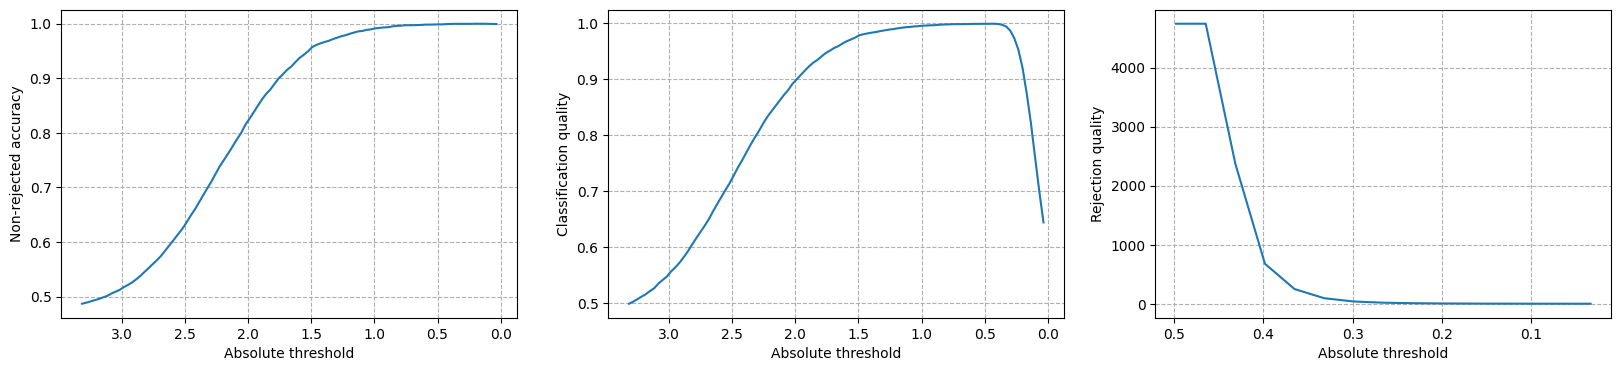

In [11]:
class RejectionPlot:
    def __init__(
        self,
        relative: bool = True,
        seed: int = 44,
        space_start: float = 0.001,
        space_stop: float = 0.99,
        space_bins: int = 100,
        num_labels: Optional[int] = None,
    ):
        self.relative = relative
        self.seed = seed
        self.space_start = space_start
        self.space_stop = space_stop
        self.space_bins = space_bins
        self.num_labels = num_labels

    def plot(
        self,
        correct: ArrayLike,
        unc_ary: Union[ArrayLike,dict[ArrayLike]],
        unc_type: Optional[str] = None,
        metric: Optional[str] = None,
        fig: Optional[plt.Figure] = None,
        filename: Optional[str] = None,
        **save_args
    ) -> plt.Figure:
        if isinstance(unc_ary, dict):
            if set(list(unc_ary.keys())) != set(["TU", "AU", "EU"]):
                raise ValueError("Invalid uncertainty dictionary keys. Should be ['TU', 'AU', 'EU'].")
            if unc_type is None and metric is None:
                raise ValueError("If `unc_ary` is a dictionary and `unc_type` is None, `metric` must not be None.")

        if isinstance(unc_type, str) and metric is not None:
            fig = self.__plot_1_panel(
                correct=correct,
                unc_ary=unc_ary if isinstance(unc_ary,(list, np.ndarray)) else unc_ary[unc_type], # TODO: check if this works
                metric=metric,
                unc_type=unc_type,
                fig=fig,
                filename=filename,
                **save_args
            )
        elif metric is None:
            fig = self.__plot_3_metric_panels(
                correct=correct,
                unc_ary=unc_ary if isinstance(unc_ary,(list, np.ndarray)) else unc_ary[unc_type], # TODO: check if this works,
                unc_type=unc_type,
                fig=fig,
                filename=filename,
                **save_args
            )
        # TODO: handle case where uncertainty type is None
        elif unc_type is None:
            fig = self.__plot_3_uncertainty_panels(
                correct=correct,
                unc_ary=unc_ary,
                metric=metric,
                fig=fig,
                filename=filename,
                **save_args
            )
        return fig

    def __plot_1_panel(
        self,
        correct: ArrayLike,
        unc_ary: ArrayLike,
        metric: str,
        unc_type: str,
        fig: Optional[plt.Figure] = None,
        filename: Optional[str] = None,
        **save_args
    ) -> plt.Figure:
        unc_types = ["TU", "AU", "EU", "confidence"]
        if unc_type not in unc_types:
            raise ValueError(
                "Invalid uncertainty type. Expected one of: %s" % unc_types
            )
        unc_type = "entropy" if unc_type in ["TU", "AU", "EU"] else "confidence"
        if (
            unc_type == "confidence"
        ):  # TODO: find other way, e.g. flip uncertainty vector
            # largest value is most uncertain
            unc_ary = 1.0 - unc_ary

        # draw routines
        if fig is None:
            fig, ax = plt.subplots()
        # use an existing figure object if given
        else:
            ax = fig.add_subplot(1, 1, 1)

        self.__plot_base_panel(
            correct=correct,
            unc_ary=unc_ary,
            metric=metric,
            unc_type=unc_type,
            ax=ax,
        )
        ax.grid(linestyle="dashed")
        if self.relative:
            ax.set(xlabel="Relative threshold", ylabel="Metric")
        else:
            ax.set(xlabel="Absolute threshold", ylabel="Metric")
        if filename is not None:
            fig.tight_layout()
            fig.savefig(filename, **save_args)
        return fig

    def __plot_3_metric_panels(
        self,
        correct: ArrayLike,
        unc_ary: ArrayLike,
        unc_type: str,
        fig: Optional[plt.Figure] = None,
        filename: Optional[str] = None,
        **save_args
    ) -> plt.Figure:
        unc_types = ["TU", "AU", "EU", "confidence"]
        if unc_type not in unc_types:
            raise ValueError(
                "Invalid uncertainty type. Expected one of: %s" % unc_types  # TODO: is this needed?
            )
        unc_type = "entropy" if unc_type in ["TU", "AU", "EU"] else "confidence"
        if unc_type == "confidence":
            # largest value is most uncertain
            unc_ary = 1.0 - unc_ary

        label_dict = {
            "nra": "Non-rejected accuracy",
            "cq": "Classification quality",
            "rq": "Rejection quality",
        }
        # draw routines
        if fig is None:
            fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
        # use an existing figure object if given
        else:
            axes = [
                fig.add_subplot(3, 1, 1),
                fig.add_subplot(3, 1, 2),
                fig.add_subplot(3, 1, 3),
            ]
        for i, label in enumerate(label_dict.keys()):
            self.__plot_base_panel(
                correct=correct,
                unc_ary=unc_ary,
                metric=label,
                unc_type=unc_type,
                ax=axes[i],
            )
            axes[i].grid(linestyle="dashed")
            if self.relative:
                axes[i].set(xlabel="Relative threshold", ylabel=label_dict[label])
            else:
                axes[i].set(xlabel="Absolute threshold", ylabel=label_dict[label])

        if filename is not None:
            fig.tight_layout()
            fig.savefig(filename, **save_args)
        return fig

    def __plot_3_uncertainty_panels(
        self,
        correct: ArrayLike,
        unc_ary: ArrayLike,
        metric: str,
        fig: Optional[plt.Figure] = None,
        filename: Optional[str] = None,
        **save_args
    ) -> plt.Figure:
        
        label_dict = {
            "nra": "Non-rejected accuracy",
            "cq": "Classification quality",
            "rq": "Rejection quality",
        }
        # unc_type = "entropy" if unc_type in ["TU", "AU", "EU"] else "confidence"
        # draw routines
        if fig is None:
            fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
        # use an existing figure object if given
        else:
            axes = [
                fig.add_subplot(3, 1, 1),
                fig.add_subplot(3, 1, 2),
                fig.add_subplot(3, 1, 3),
            ]
        for i, unc_type in enumerate(["TU", "AU", "EU"]):
            self.__plot_base_panel(
                correct=correct,
                unc_ary=unc_ary[unc_type],
                metric=metric,
                unc_type="entropy",
                ax=axes[i],
            )
            axes[i].grid(linestyle="dashed")
            if self.relative:
                axes[i].set(xlabel="Relative threshold", ylabel=label_dict[metric])
            else:
                axes[i].set(xlabel="Absolute threshold", ylabel=label_dict[metric])

        if filename is not None:
            fig.tight_layout()
            fig.savefig(filename, **save_args)
        return fig

    def __plot_base_panel(
        self,
        correct: ArrayLike,
        unc_ary: ArrayLike,
        metric: str,
        unc_type: str,
        ax: Optional[plt.Axes] = None,
    ) -> plt.Axes:
        unc_types = ["entropy", "confidence"]
        if unc_type not in unc_types:
            raise ValueError(
                "Invalid uncertainty type. Expected one of: %s" % unc_types
            )
        if self.relative:
            treshold_ary = np.linspace(
                start=self.space_start, stop=self.space_stop, num=self.space_bins
            )
            reject_ary = treshold_ary
            plot_ary = treshold_ary
        elif not self.relative and unc_type == "confidence":
            treshold_ary = np.linspace(
                start=(1 - self.space_start),
                stop=(1 - self.space_stop),
                num=self.space_bins,
            )
            reject_ary = treshold_ary
            plot_ary = np.flip(treshold_ary, axis=0)
        elif not self.relative and unc_type == "entropy":
            if self.num_labels is not None:
                max_entropy = np.log2(self.num_labels)
            else:
                max_entropy = np.max(unc_ary)
            treshold_ary = np.linspace(
                start=(1 - self.space_start) * max_entropy,
                stop=(1 - self.space_stop) * max_entropy,
                num=self.space_bins,
            )
            reject_ary = treshold_ary
            plot_ary = treshold_ary

        compute_metrics_rej_v = np.vectorize(
            compute_metrics_rej,
            excluded=["correct", "unc_ary", "show", "relative", "seed"],
        )
        nonrej_acc, class_quality, rej_quality = compute_metrics_rej_v(
            reject_ary,
            correct=correct,
            unc_ary=unc_ary,
            show=False,
            relative=self.relative,
            seed=self.seed,
        )

        # plot on existing axis or new axis
        if ax is None:
            ax = plt.gca()
        if metric == "nra":
            ax.plot(plot_ary, nonrej_acc)
        elif metric == "cq":
            ax.plot(plot_ary, class_quality)
        elif metric == "rq":
            ax.plot(plot_ary, rej_quality)

        if not self.relative and unc_type == "entropy":
            # invert x-axis, largest uncertainty values on the left
            ax.invert_xaxis()
        return ax

# # test __plot_1_panel, absolute threshold, total uncertainty
# fig = RejectionPlot(relative=False, num_labels=10).plot(
#     correct=y_pred_correct,
#     unc_ary=y_pred_uncertainty,
#     metric="nra",
#     unc_type="TU",
# )
# # test __plot_1_panel, relative threshold, total uncertainty
# fig = RejectionPlot(relative=True, num_labels=10).plot(
#     correct=y_pred_correct,
#     unc_ary=y_pred_uncertainty,
#     metric="nra",
#     unc_type="TU",
# )

# # test __plot_3_metric_panels, absolute threshold, total uncertainty
# fig = RejectionPlot(relative=False, num_labels=10).plot(
#     correct=y_pred_correct,
#     unc_ary=y_pred_uncertainty,
#     metric=None,
#     unc_type="TU",
# )
# # test __plot_3_metric_panels, relative threshold, total uncertainty
# fig = RejectionPlot(relative=True, num_labels=10).plot(
#     correct=y_pred_correct,
#     unc_ary=y_pred_uncertainty,
#     metric=None,
#     unc_type="TU",
# )
    
# # test __plot_1_panel, absolute threshold, confidence
# fig = RejectionPlot(relative=False, num_labels=10).plot(
#     correct=y_pred_correct,
#     unc_ary=y_pred_confidence,
#     metric="nra",
#     unc_type="confidence",
# )
# # test __plot_1_panel, relative threshold, confidence
# fig = RejectionPlot(relative=True, num_labels=10).plot(
#     correct=y_pred_correct,
#     unc_ary=y_pred_confidence,
#     metric="nra",
#     unc_type="confidence",
# )

# # test __plot_3_metric_panels, absolute threshold, confidence
# fig = RejectionPlot(relative=False, num_labels=10).plot(
#     correct=y_pred_correct,
#     unc_ary=y_pred_confidence,
#     metric=None,
#     unc_type="confidence",
# )
# # test __plot_3_metric_panels, relative threshold, confidence
# fig = RejectionPlot(relative=True, num_labels=10).plot(
#     correct=y_pred_correct,
#     unc_ary=y_pred_confidence,
#     metric=None,
#     unc_type="confidence",
# )
    
# # test __plot_1_panel, absolute threshold, uncertainty dict
# fig = RejectionPlot(relative=False, num_labels=10).plot(
#     correct=y_pred_correct,
#     unc_ary=uncertainty_dict,
#     metric="nra",
#     unc_type="TU",
# )

# # test __plot_1_panel, absolute threshold, uncertainty dict
# fig = RejectionPlot(relative=False, num_labels=10).plot(
#     correct=y_pred_correct,
#     unc_ary=uncertainty_dict,
#     metric="nra",
#     unc_type=None,
# )

# test __plot_1_panel, absolute threshold, uncertainty dict
fig = RejectionPlot(relative=False, num_labels=10).plot(
    correct=y_pred_correct,
    unc_ary=uncertainty_dict,
    metric=None,
    unc_type="TU",
)


